Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3436 - rounded_accuracy: 0.8281 - val_loss: 0.2488 - val_rounded_accuracy: 0.8744
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2425 - rounded_accuracy: 0.8802 - val_loss: 0.2271 - val_rounded_accuracy: 0.8905
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2260 - rounded_accuracy: 0.8906 - val_loss: 0.2151 - val_rounded_accuracy: 0.8975
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2124 - rounded_accuracy: 0.8999 - val_loss: 0.2010 - val_rounded_accuracy: 0.9083
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1992 - rounded_accuracy: 0.9103 - val_loss: 0.1910 - val_rounded_accuracy: 0.9160
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1911 - rounded_accuracy: 0.9163 - val_loss: 0.1862 - val_rounded_accuracy: 0.9202
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1863 - rounded_accuracy: 0.9197 - val_loss: 0.1816 - val_rounded_accurac

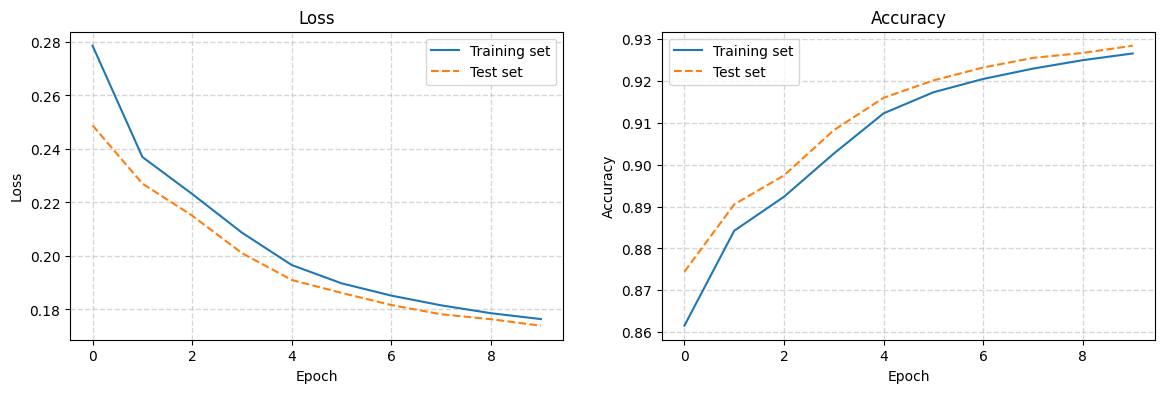

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step


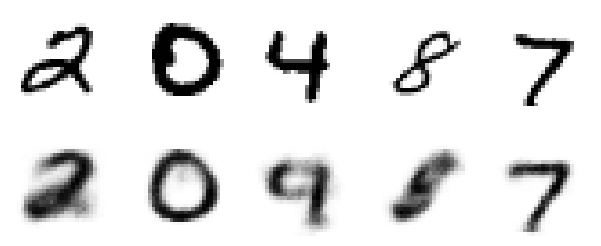

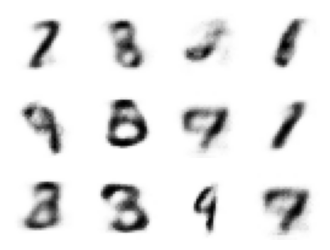

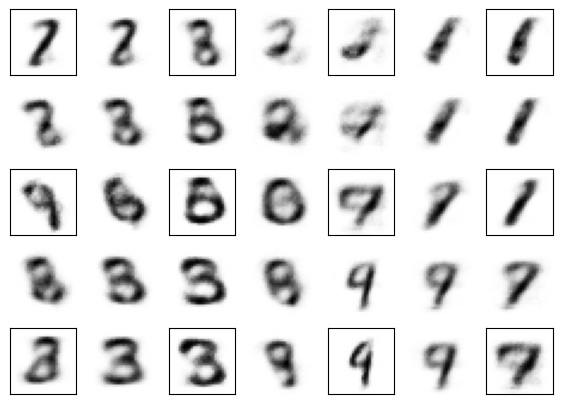

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, Conv2DTranspose, Reshape, Layer
import matplotlib.pyplot as plt
import numpy as np

tf.__version__, tf.test.gpu_device_name()

(x_train_m, _), (x_test_m, _) = tfds.as_numpy(tfds.load('mnist', split=['train','test'], batch_size=-1, as_supervised=True, try_gcs=True))

x_train_m.shape, x_test_m.shape

mnist_shape = x_train_m.shape[1:]
mnist_shape

x_train_fds, x_test_fds = x_train_m.astype(np.float32) / 255, x_test_m.astype(np.float32) / 255

class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var / 2) + mean

class KLDivergenceLayer(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.square(mean) - tf.exp(log_var),
            axis=-1
        )
        self.add_loss(tf.reduce_mean(kl_loss) / 784.)
        return mean

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

codings_size = 10
inputs = Input(shape=mnist_shape)
z = Flatten()(inputs)
z = Dense(128, activation='relu')(z)
z = Dense(64, activation='relu')(z)
z = Dense(32, activation='relu')(z)
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)

codings_mean = KLDivergenceLayer()([codings_mean, codings_log_var])

codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(32, activation='relu')(decoder_inputs)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(28 * 28, activation='sigmoid')(x)
outputs = Reshape(mnist_shape)(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(
        tf.round(y_true), tf.round(y_pred))

variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[rounded_accuracy])

vae_history = variational_ae.fit(x_train_fds, x_train_fds, epochs=10, batch_size=128, validation_data=(x_test_fds, x_test_fds))

def viz_history(training_history):
  loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  accuracy = training_history.history['rounded_accuracy']
  val_accuracy = training_history.history['val_rounded_accuracy']
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(loss, label='Training set')
  plt.plot(val_loss, label='Test set', linestyle='--')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)
  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(accuracy, label='Training set')
  plt.plot(val_accuracy, label='Test set', linestyle='--')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)
  plt.show()

viz_history(vae_history)

x_test_fds.shape

x_test_fds_imgs = tf.squeeze(x_test_fds)
x_test_fds_imgs.shape

def show_reconstructions(model, images, n_images, reshape=False):
  reconstructions = model.predict(images[:n_images])
  if reshape:
    reconstructions = tf.squeeze(reconstructions)
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

def plot_image(image):
  plt.imshow(image, cmap='binary')
  plt.axis('off')

show_reconstructions(variational_ae, x_test_fds_imgs, 5, reshape=True)

def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

tf.random.set_seed(0)
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

tf.random.set_seed(0)
np.random.seed(0)
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()
images.shape

images = tf.squeeze(images)

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
  plt.subplot(5, 7, index + 1)
  if index%7%2==0 and index//7%2==0:
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
  else:
    plt.axis('off')
  plt.imshow(image, cmap='binary')